In [85]:
#!pip install pandas numpy scikit-learn scipy seaborn matplotlib phenograph

In [2]:
import pandas as pd
import numpy as np 
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt
import phenograph
from sklearn.manifold import TSNE
import sys
sys.path.append('/dss/dsshome1/0F/di93quv/Systems_biomedicine/acdc/')
from ACDC.cell_type_annotation import *
import ACDC
import matplotlib as mpl
import matplotlib.patches as mpatches
%matplotlib inline 

In [3]:
# Load the data
path = '/dss/dsshome1/0F/di93quv/Systems_biomedicine/acdc/data/BMMC_benchmark/'
df = pd.read_csv(path + 'BMMC_benchmark.csv.gz', sep=',', header=0, compression='gzip')
df

,CD45,CD45RA,CD19,CD11b,CD4,CD8,CD34,CD20,CD33,CD123,CD38,CD90,CD3,cell_type
0,57.538193,12.118988,2.750747,-0.524355,4.516802,13.814429,2.783628,-0.772090,182.590073,33.992813,260.543274,15.497443,8.296851,CD11b- Monocyte
1,81.632271,23.402050,1.572761,4.666382,11.255368,15.168184,-0.165119,1.473974,267.255981,11.038920,175.833466,2.175224,0.334277,CD11b- Monocyte
2,21.073702,4.419225,-0.581668,0.936641,2.775233,4.676502,4.011384,11.760817,219.051987,2.290826,227.592499,0.624691,-19.434338,CD11b- Monocyte
3,188.290024,0.838968,-3.417756,-0.104915,14.933697,-0.472276,9.698525,-0.141082,183.407196,31.706251,372.540466,8.751083,-5.999844,CD11b- Monocyte
4,34.643852,3.886593,-0.873833,-0.212112,2.331734,11.722796,3.993211,0.698421,153.135605,11.620628,396.124970,3.380061,-3.817446,CD11b- Monocyte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
167039,30.217901,17.152798,47.766022,2.279454,1.713066,-1.566837,57.375442,2.729135,5.714800,47.347561,1348.691650,1.051744,35.071564,Pre-B I
167040,15.661649,1.538345,26.243685,-0.151768,-0.668272,1.213546,36.449871,-0.301972,-0.544208,0.126553,396.024689,0.063682,0.506850,Pre-B I
167041,15.963311,9.536336,44.956116,-0.246112,-0.527353,-0.119489,51.079742,2.544638,-0.402277,8.599491,346.169220,2.277662,43.345062,Pre-B I
167042,22.508121,8.423149,85.642662,-0.684507,2.281956,-0.571766,57.077110,-0.358109,35.434849,6.709400,643.495300,5.975453,8.842566,Pre-B I


In [4]:
# Data preprocessing
channels = ['CD45','CD45RA', 'CD19', 'CD11b', 'CD4', 'CD8', 'CD34', 'CD20', 'CD33', 'CD123', 'CD38', 'CD90', 'CD3']
df = df[df.cell_type != 'NotGated']
df[channels] = np.arcsinh((df[channels].values - 1.0)/5.0)  # Arc-sinh transformation

/tmp/ipykernel_3969247/61843277.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[channels] = np.arcsinh((df[channels].values - 1.0)/5.0)  # Arc-sinh transformation


In [41]:
# Extract features and labels
y0 = df.cell_type.values
df = df.drop('cell_type', axis=1)
X0 = df.to_numpy()
df

,CD45,CD45RA,CD19,CD11b,CD4,CD8,CD34,CD20,CD33,CD123,CD38,CD90,CD3
0,3.120575,1.539464,0.343363,-0.300336,0.655417,1.670336,0.349563,-0.347389,4.285651,2.585692,4.642725,1.786173,1.172012
1,3.474568,2.205089,0.114303,0.679715,1.466246,1.764482,-0.230965,0.094653,4.668256,1.447111,4.247748,0.232933,-0.132754
2,2.098281,0.639382,-0.311282,-0.012672,0.347981,0.681346,0.570776,1.509685,4.468574,0.255380,4.506984,-0.074991,-2.115569
3,4.316546,-0.032201,-0.796591,-0.219223,1.748759,-0.290358,1.320779,-0.226280,4.290139,2.514739,5.001412,1.222299,-1.137964
4,2.605016,0.549279,-0.366506,-0.240109,0.263294,1.506476,0.567660,-0.060279,4.108751,1.497807,5.062951,0.459654,-0.855319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
167039,2.465733,1.888939,2.931712,0.253177,0.142134,-0.493136,3.117704,0.339280,0.840460,2.922775,6.289861,0.010349,2.617513
167040,1.796827,0.107462,2.321952,-0.228364,-0.327755,0.042696,2.656766,-0.257538,-0.304131,-0.173813,5.062698,-0.186186,-0.098471
167041,1.816123,1.304499,2.870120,-0.246712,-0.300909,-0.222068,2.999809,0.304213,-0.276903,1.205750,4.927797,0.252830,2.833029
167042,2.165385,1.186207,3.523019,-0.330833,0.253662,-0.309394,3.112419,-0.268388,2.628008,0.978227,5.549084,0.877898,1.232176


In [42]:
X0

array([[ 3.12057517,  1.53946411,  0.34336251, ...,  4.64272548,
         1.78617349,  1.1720125 ],
       [ 3.47456814,  2.2050892 ,  0.11430317, ...,  4.24774757,
         0.2329326 , -0.13275426],
       [ 2.09828143,  0.63938162, -0.31128225, ...,  4.50698422,
        -0.07499143, -2.1155685 ],
       ...,
       [ 1.8161235 ,  1.3044992 ,  2.87012021, ...,  4.92779651,
         0.25283012,  2.83302858],
       [ 2.16538462,  1.18620702,  3.52301892, ...,  5.54908391,
         0.87789784,  1.23217643],
       [ 2.39694315,  1.07520312,  3.10080437, ...,  5.58275683,
        -0.33885769,  3.33575474]])

In [43]:
# Read cell type-marker table
table = pd.read_csv(path + 'BMMC_table.csv', sep=',', header=0, index_col=0)
table = table.fillna(0)
table

,CD45,CD45RA,CD19,CD11b,CD4,CD8,CD34,CD20,CD33,CD123,CD38,CD90,CD3
Mature CD4+ T,1.0,-1.0,-1,0.0,1,-1,0.0,0.0,-1,0.0,-1.0,0.0,1
Mature CD8+ T,1.0,-1.0,-1,0.0,-1,1,0.0,0.0,-1,0.0,-1.0,0.0,1
Naive CD4+ T,1.0,1.0,-1,0.0,1,-1,0.0,0.0,-1,0.0,-1.0,0.0,1
Naive CD8+ T,1.0,1.0,-1,0.0,-1,1,0.0,0.0,-1,0.0,-1.0,0.0,1
CD11bhi Monocyte,1.0,0.0,-1,1.0,-1,-1,-1.0,0.0,1,0.0,0.0,0.0,-1
CD11b- Monocyte,1.0,0.0,-1,-1.0,-1,-1,-1.0,0.0,1,0.0,0.0,0.0,-1
Pre-B I,0.0,0.0,1,0.0,-1,-1,1.0,-1.0,-1,0.0,1.0,0.0,-1
Pre-B II,0.0,0.0,1,0.0,-1,-1,-1.0,-1.0,-1,0.0,1.0,0.0,-1
Immature B,0.0,0.0,1,0.0,-1,-1,-1.0,-1.0,-1,0.0,-1.0,0.0,-1
Mature CD38lo B,0.0,0.0,1,0.0,-1,-1,-1.0,1.0,-1,0.0,-1.0,0.0,-1


In [44]:
# Compute marker model
mk_model = compute_marker_model(df, table, 0.0)

In [45]:
mk_model

{'CD45': (array([1.93816699, 4.56307964]),
  array([1.81288066, 0.12827167]),
  array([0.17584781, 0.82415219])),
 'CD45RA': (array([0.88013828, 3.50033393]),
  array([0.35154763, 0.41308848]),
  array([0.51603256, 0.48396744])),
 'CD19': (array([0.49861635, 2.98203839]),
  array([0.15418096, 0.41398513]),
  array([0.60471276, 0.39528724])),
 'CD11b': (array([0.73754795, 2.9796129 ]),
  array([0.29281927, 0.65798765]),
  array([0.77652546, 0.22347454])),
 'CD4': (array([1.03926857, 3.98518315]),
  array([0.67367301, 0.1826385 ]),
  array([0.52496246, 0.47503754])),
 'CD8': (array([0.93684423, 4.70074756]),
  array([0.43773083, 0.28720971]),
  array([0.63675192, 0.36324808])),
 'CD34': (array([0.44265334, 1.32156116]),
  array([0.1035531 , 0.50834701]),
  array([0.62831135, 0.37168865])),
 'CD20': (array([0.55017415, 2.27247565]),
  array([0.17243675, 0.74667242]),
  array([0.6909805, 0.3090195])),
 'CD33': (array([0.95935366, 4.73703016]),
  array([0.54657923, 0.19944173]),
  array([0.

In [46]:
# Define helper dictionaries
idx2ct = [key for idx, key in enumerate(table.index)]
idx2ct.append('unknown')

ct2idx = {key: idx for idx, key in enumerate(table.index)}
ct2idx['unknown'] = len(table.index)

In [47]:
ct2idx

{'Mature CD4+ T': 0,
 'Mature CD8+ T': 1,
 'Naive CD4+ T': 2,
 'Naive CD8+ T': 3,
 'CD11bhi Monocyte': 4,
 'CD11b- Monocyte': 5,
 'Pre-B I': 6,
 'Pre-B II': 7,
 'Immature B': 8,
 'Mature CD38lo B': 9,
 'Mature CD38mid B': 10,
 'NK': 11,
 'Plasmacytoid DC': 12,
 'CMP': 13,
 'GMP': 14,
 'HSC': 15,
 'MEP': 16,
 'MPP': 17,
 'Plasma cell': 18,
 'unknown': 19}

In [83]:
import importlib
import ACDC.cell_type_annotation 

importlib.reload(ACDC.cell_type_annotation)  

from ACDC.cell_type_annotation import get_score_mat
print(get_score_mat.__doc__)


    Compute the cluster x annotation score matrix..
    Parameters:
    - X: sample x feature data matrix
    - weights: weights for scoring
    - table: a list of (ind, sign)
    - y_cluster: cluster labels for each sample (can be empty or None)
    - mk_model: model-making function
    


In [74]:
# Score computation
score0 = get_score_mat(X0, [], table, [], mk_model)
score0 = np.concatenate([score0, 1.0 - score0.max(axis=1)[:, np.newaxis]], axis=1)

In [75]:
# Compute unique index for clusters
thres = 0.5
ct_index0 = get_unique_index(X0, score0, table, thres)

In [76]:
# Average heatmap for cluster scores
ave_mat = []
for i, ct in enumerate(table.index):
    item = X0[ct_index0[:, i] == 1, :] if np.any(ct_index0[:, i] == 1) else X0[score0[:, i] > thres, :]
    ave_mat.append(np.mean(item, axis=0))
    
ave_mat = np.vstack(ave_mat)

In [77]:
# Manual gating average heatmap
ct_mat = np.vstack([np.mean(X0[y0 == ct, :], axis=0) for ct in table.index])

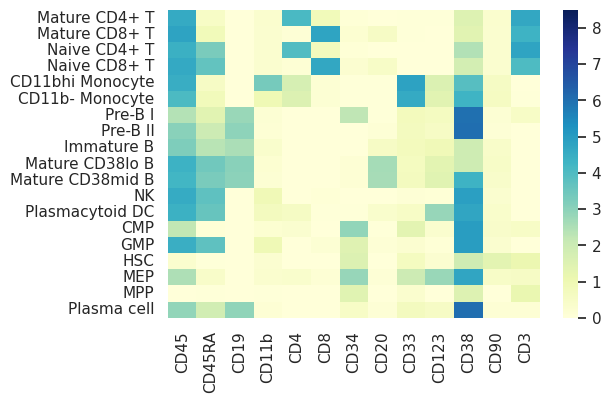

In [78]:
# Plotting heatmap
sns.set()
fig = plt.figure(figsize=(6, 4))
feature_mat_df = pd.DataFrame(ave_mat, columns=table.columns, index=table.index)
ax = sns.heatmap(feature_mat_df, vmin=0.0, vmax=8.5, cmap="YlGnBu")
plt.xticks(rotation=90)
plt.show()

In [ ]:
## average heatmap from manual gating
ct_feature_df = pd.DataFrame(ct_mat, columns = table.columns, index = table.index)
ax = sns.heatmap(ct_feature_df, vmin=0.0, vmax=8.5, cmap="YlGnBu")
locs, labels = plt.xticks()
plt.setp(labels, rotation=90)
plt.show()

In [79]:
# Compute landmarks and visualize
res_c = get_landmarks(X0, score0, ct_index0, idx2ct, phenograph, thres)
landmark_mat, landmark_label = output_feature_matrix(res_c, [idx2ct[i] for i in range(len(idx2ct))])

Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 6.1655309200286865 seconds
Jaccard graph constructed in 3.0198216438293457 seconds
Wrote graph to binary file in 0.3203129768371582 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.649988
After 4 runs, maximum modularity is Q = 0.653901
After 19 runs, maximum modularity is Q = 0.655033
Louvain completed 39 runs in 19.8919460773468 seconds
Sorting communities by size, please wait ...
PhenoGraph completed in 30.221262454986572 seconds
Finding 30 nearest neighbors using minkowski metric and 'auto' algorithm
Neighbors computed in 2.5754854679107666 seconds
Jaccard graph constructed in 2.231074810028076 seconds
Wrote graph to binary file in 0.19841790199279785 seconds
Running Louvain modularity optimization
After 1 runs, maximum modularity is Q = 0.601659
After 3 runs, maximum modularity is Q = 0.605663
After 6 runs, maximum modularity is Q = 0.607498
After

In [80]:
X_plot = [landmark_mat.copy()]
y_plot = landmark_label[:]
for key in idx2ct:
    tmp = X0[y0 == key, :]
    tmp = tmp[:1000, :] if tmp.shape[0] > 1000 else tmp
    y_plot += [key] * tmp.shape[0]
    X_plot.append(tmp)

X_plot = np.vstack(X_plot)
y_plot = np.array(y_plot)

# t-SNE transformation
tsne = TSNE(n_components=2, random_state=0)
Xre = tsne.fit_transform(X_plot)

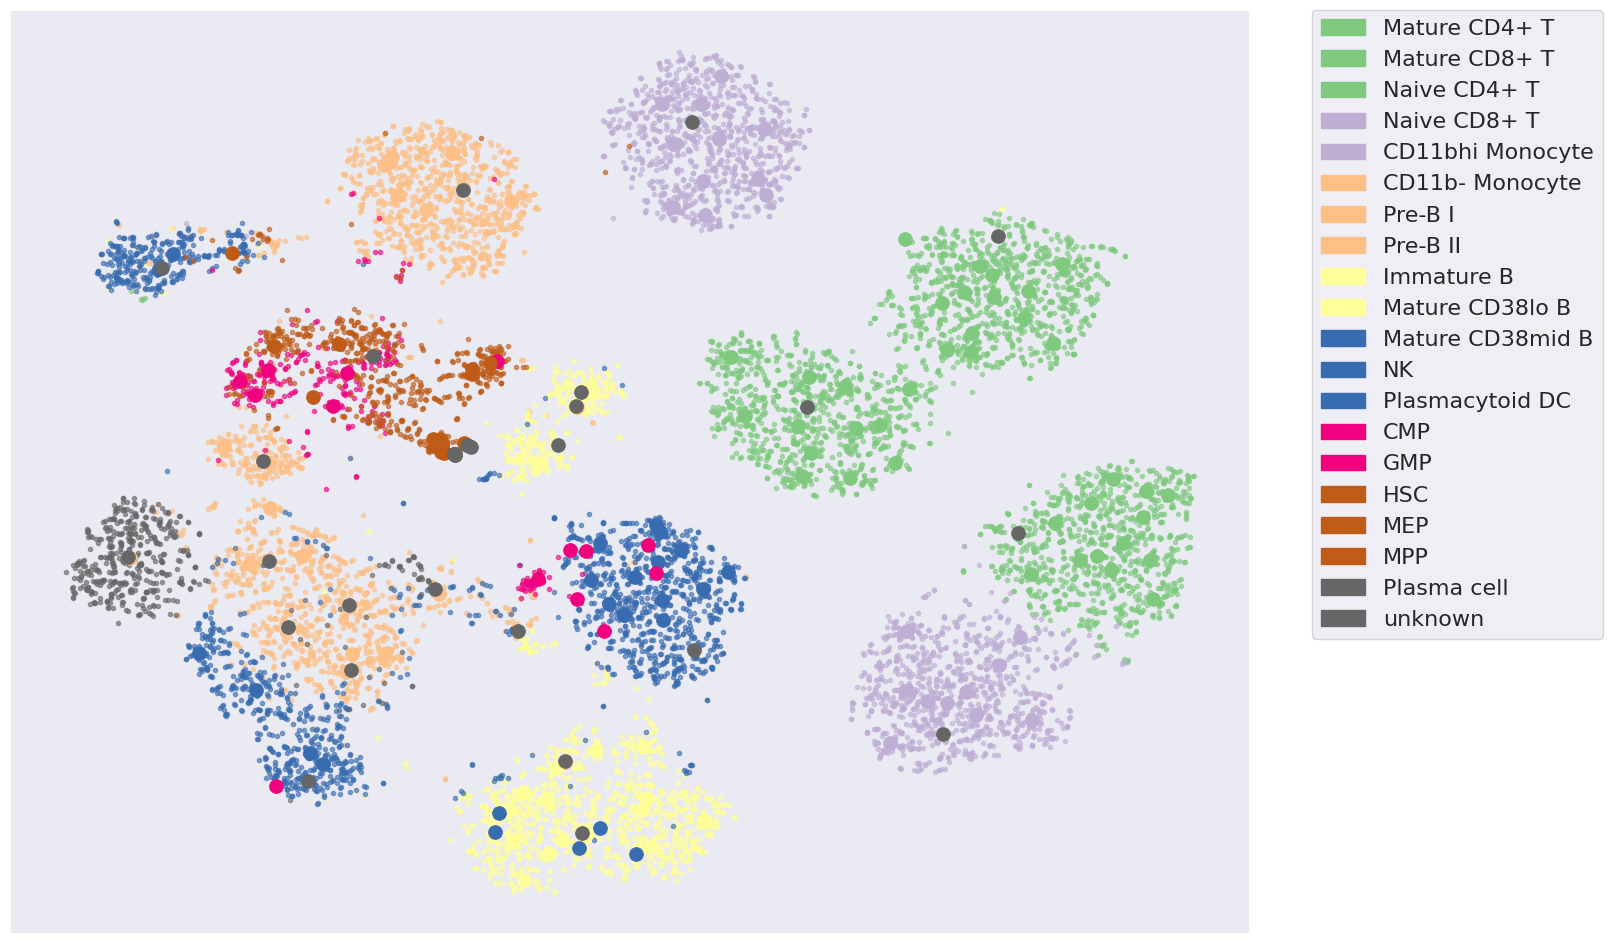

In [84]:
# Plottingt-SNE
cmap = plt.cm.Accent
fig = plt.figure(1, figsize=(16, 12))

for idx, key in enumerate(idx2ct):
    plt.plot(Xre[y_plot == key, 0], Xre[y_plot == key, 1], '.', color=cmap(idx / len(idx2ct)), alpha=0.6, label=key)

for idx, key in enumerate(landmark_label):
    ax, ay = Xre[idx, 0], Xre[idx, 1]
    plt.plot(ax, ay, 'o', color=cmap(ct2idx[key] / len(idx2ct)), alpha=1, markersize=10, markeredgewidth=0.5)

plt.legend(handles=[mpatches.Patch(color=cmap(idx / len(idx2ct)), label=key) for idx, key in enumerate(idx2ct)],
           bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., prop={'size': 16})

plt.xticks([])
plt.yticks([])
plt.show()